In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv
/kaggle/input/porto-seguro-safe-driver-prediction/train.csv
/kaggle/input/porto-seguro-safe-driver-prediction/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

**Data Cleaning**

In [3]:
train=pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv', na_values=-1)
test=pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv', na_values=-1)
train.shape

(595212, 59)

In [4]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
train.isnull().values.any()


True

      column_name  missing_count
35      ps_car_12              1
24  ps_car_02_cat              5
34      ps_car_11              5
5   ps_ind_04_cat             83
23  ps_car_01_cat            107
3   ps_ind_02_cat            216
31  ps_car_09_cat            569
6   ps_ind_05_cat           5809
29  ps_car_07_cat          11489
37      ps_car_14          42620
22      ps_reg_03         107772
27  ps_car_05_cat         266551
25  ps_car_03_cat         411231


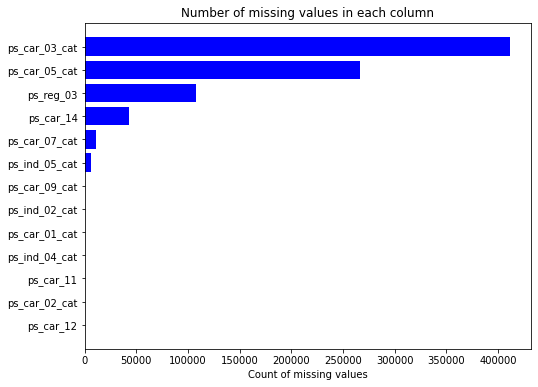

In [6]:
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
print(missing_df)

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,6))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [7]:
features = train.drop(['id','target'], axis=1).values
targets = train.target.values

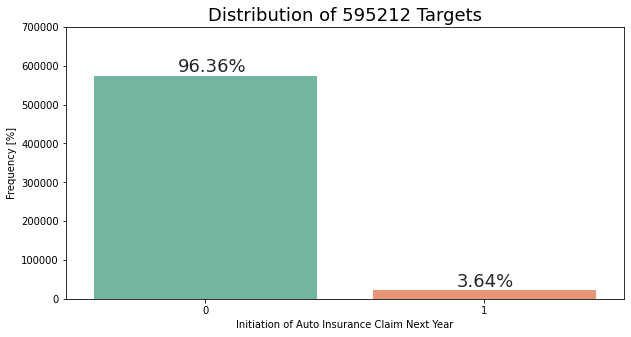

In [8]:
ax = sns.countplot(x = targets ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

In [9]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


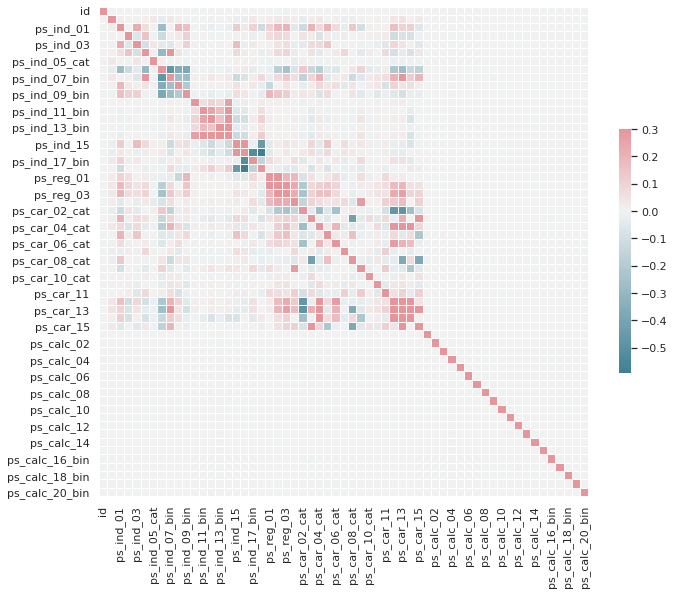

In [10]:
sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

**Training**

In [11]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score


In [12]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1)

In [13]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold,shuffle=True, random_state=42)

In [14]:
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }


In [15]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

In [16]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [17]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold

[Fold 1/5]
[15:33:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:33:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67331	train-gini:0.05250	valid-logloss:0.67276	valid-gini:0.06626
[100]	train-logloss:0.16521	train-gini:0.31721	valid-logloss:0.16602	valid-gini:0.27480
[200]	train-logloss:0.14968	train-gini:0.35881	valid-logloss:0.15221	valid-gini:0.28454
[300]	train-logloss:0.14743	train-gini:0.39701	valid-logloss:0.15161	valid-gini:0.29014
[400]	train-logloss:0.14605	train-gini:0.42340	val

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[Fold 2/5]
[15:38:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:38:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67332	train-gini:0.06412	valid-logloss:0.67276	valid-gini:0.04369
[100]	train-logloss:0.16514	train-gini:0.32067	valid-logloss:0.16609	valid-gini:0.26531
[200]	train-logloss:0.14957	train-gini:0.36196	valid-logloss:0.15240	valid-gini:0.27558
[300]	train-logloss:0.14730	train-gini:0.39934	valid-logloss:0.15188	valid-gini:0.28131
[400]	train-logloss:0.14586	train-gini:0.42807	val

In [18]:
sub.to_csv('kfold_stratified_xgboost.csv', index=False)